In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec
import json
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

api = wandb.Api(timeout=19)

In [3]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [4]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

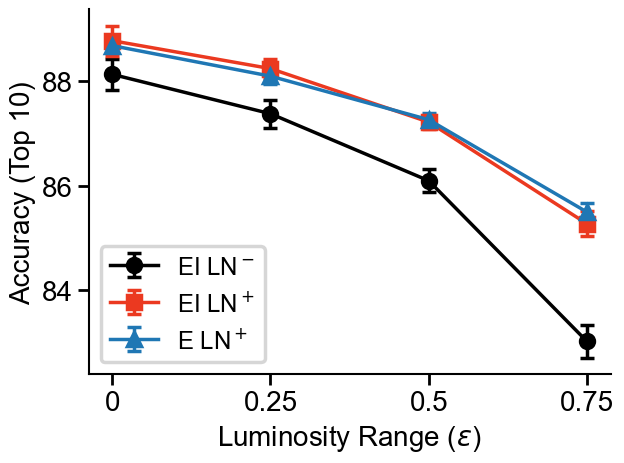

In [11]:
fig, ax = plt.subplots()
brightness_factor = [0, 0.25, 0.5, 0.75]
best_n_runs = 10

noln_acc = []
ln_acc = []
e_ln_acc = []

noln_err = []
ln_err = []
e_ln_err = []

for bf in brightness_factor:

    # --- EI Network, LN+ ---
    layernorm_ei_network = fetch_runs(
        api, entity='project_danns', project_name='Luminosity_LNHomeostasis',
        filters={
            "config.dataset": "fashionmnist",
            "config.brightness_factor": bf,
            "config.layer_norm": 1,
            "config.excitation_training": 0,
            "config.normtype_detach": 0,
            "config.use_testset": True,
            "config.homeostasis": 0
        },
        order="-summary_metrics.test_acc"
    )[:best_n_runs]

    # --- EI Network, LN- ---
    no_layernorm_ei_network = fetch_runs(
        api, entity='project_danns', project_name='Luminosity_LNHomeostasis',
        filters={
            "config.dataset": "fashionmnist",
            "config.brightness_factor": bf,
            "config.layer_norm": 0,
            "config.excitation_training": 0,
            "config.normtype_detach": 0,
            "config.use_testset": True,
            "config.homeostasis": 0
        },
        order="-summary_metrics.test_acc"
    )[:best_n_runs]

    # --- E-Only Network, LN+ ---
    layernorm_e_network = fetch_runs(
        api, entity='project_danns', project_name='Luminosity_LNHomeostasis',
        filters={
            "config.dataset": "fashionmnist",
            "config.brightness_factor": bf,
            "config.homeostasis": 0,
            "config.normtype": 0,
            "config.normtype_detach": 0,
            "config.excitation_training": 1,
            "config.layer_norm": 1,
            "config.use_testset": True
        },
        order="-summary_metrics.test_acc"
    )[:best_n_runs]

    # --- Compute summary stats ---
    noln_vals = [run.summary['test_acc'] for run in no_layernorm_ei_network]
    ln_vals   = [run.summary['test_acc'] for run in layernorm_ei_network]
    e_ln_vals = [run.summary['test_acc'] for run in layernorm_e_network]

    noln_acc.append(np.median(noln_vals))
    ln_acc.append(np.median(ln_vals))
    e_ln_acc.append(np.median(e_ln_vals))

    noln_err.append(np.std(noln_vals))
    ln_err.append(np.std(ln_vals))
    e_ln_err.append(np.std(e_ln_vals))


# -------------------------------------
# PLOTS
# -------------------------------------

# LN– EI network
ax.errorbar(
    range(len(noln_acc)), noln_acc, yerr=noln_err,
    fmt='-o', label='EI LN$^-$',
    capsize=5, color='black'
)

# LN+ EI network
ax.errorbar(
    range(len(ln_acc)), ln_acc, yerr=ln_err,
    fmt='-s', label='EI LN$^+$',
    capsize=5, color='#eb3920'
)

# LN+ E-only network (NEW)
ax.errorbar(
    range(len(e_ln_acc)), e_ln_acc, yerr=e_ln_err,
    fmt='-^', label='E LN$^+$',
    capsize=5, color='#1f77b4'   # blueish default for contrast
)

# -------------------------------------

plt.xticks(range(len(noln_acc)), [str(ele) for ele in brightness_factor], fontsize=25)
plt.legend()

ax.set_xlabel('Luminosity Range ($\\varepsilon$)', fontsize=20)
ax.set_ylabel(f'Accuracy (Top {best_n_runs})', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig("figure1d.svg", format="svg")


Mann–Whitney U p-value: 0.7581321119576172


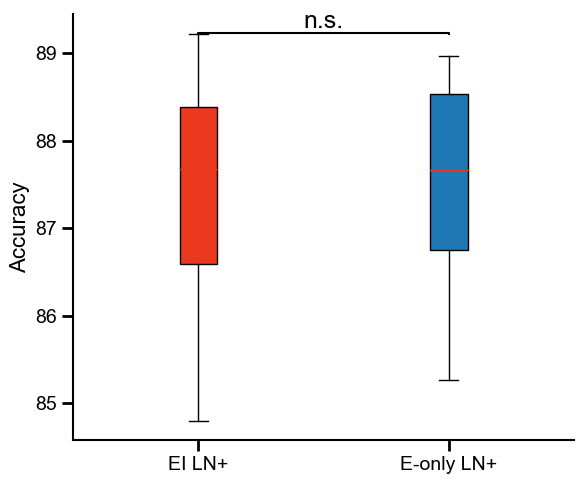

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# ---------------------------------------
# Collect values across luminosity levels
# ---------------------------------------

brightness_factor = [0, 0.25, 0.5, 0.75]
best_n_runs = 10

ln_vals_all = []      # EI LN+
e_ln_vals_all = []    # E-only LN+

for bf in brightness_factor:

    layernorm_ei_network = fetch_runs(
        api, entity='project_danns', project_name='Luminosity_LNHomeostasis',
        filters={
            "config.dataset": "fashionmnist",
            "config.brightness_factor": bf,
            "config.layer_norm": 1,
            "config.excitation_training": 0,
            "config.normtype_detach": 0,
            "config.use_testset": True,
            "config.homeostasis": 0
        },
        order="-summary_metrics.test_acc"
    )[:best_n_runs]

    layernorm_e_network = fetch_runs(
        api, entity='project_danns', project_name='Luminosity_LNHomeostasis',
        filters={
            "config.dataset": "fashionmnist",
            "config.brightness_factor": bf,
            "config.homeostasis": 0,
            "config.normtype": 0,
            "config.normtype_detach": 0,
            "config.excitation_training": 1,
            "config.layer_norm": 1,
            "config.use_testset": True
        },
        order="-summary_metrics.test_acc"
    )[:best_n_runs]

    ln_vals_all.extend([run.summary["test_acc"] for run in layernorm_ei_network])
    e_ln_vals_all.extend([run.summary["test_acc"] for run in layernorm_e_network])


# ---------------------------------------
# Statistical Test
# ---------------------------------------

stat, p = mannwhitneyu(ln_vals_all, e_ln_vals_all, alternative="two-sided")
print("Mann–Whitney U p-value:", p)

# Stars
if p < 0.001:
    stars = "***"
elif p < 0.01:
    stars = "**"
elif p < 0.05:
    stars = "*"
else:
    stars = "n.s."


# ---------------------------------------
# Boxplot
# ---------------------------------------

fig, ax = plt.subplots(figsize=(6, 5))

box = ax.boxplot(
    [ln_vals_all, e_ln_vals_all],
    labels=["EI LN+", "E-only LN+"],
    patch_artist=True
)

# Colors
box['boxes'][0].set(facecolor="#eb3920")   # red-ish
box['boxes'][1].set(facecolor="#1f77b4")   # blue-ish

# ---------------------------------------
# Significance bar
# ---------------------------------------

y_max = max(max(ln_vals_all), max(e_ln_vals_all))
h = 0.01  # height of the bar

x1, x2 = 1, 2

ax.plot([x1, x1, x2, x2], [y_max, y_max + h, y_max + h, y_max], lw=1.5, c='black')
ax.text((x1 + x2) * 0.5, y_max + h * 1.1, stars, ha='center', va='bottom', fontsize=18)

# ---------------------------------------

ax.set_ylabel("Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig("figure1f.svg", format="svg")
plt.show()


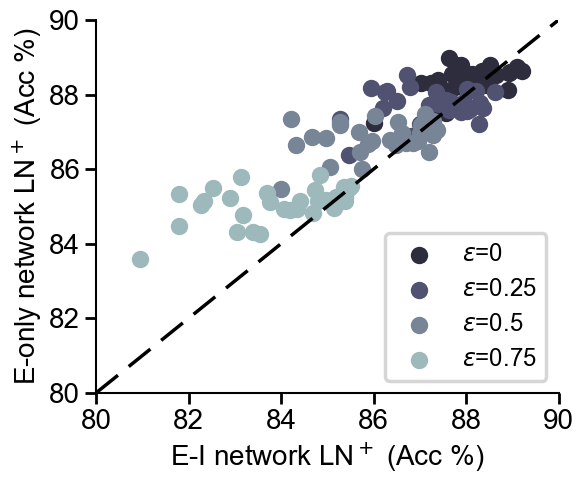

In [9]:
fig, ax = plt.subplots(figsize=(6,5))

# Example brightness factors used
brightness_values = [0, 0.25, 0.5, 0.75]

# Normalize brightness for colormap mapping
norm = mcolors.Normalize(vmin=min(brightness_values), vmax=max(brightness_values))

def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Create a grayscale colormap from 20% (dark gray) to 100% (black)
cmap = truncate_colormap(plt.get_cmap('bone'), 0.2, 0.7)
list_line = range(100)

scatter_handles = []  # For legend proxy if needed

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.plot(list_line, list_line, color='black', linestyle='--')
ax.set_xlabel(f"E-I network LN$^+$ (Acc %)", fontsize=20)
ax.set_ylabel("E-only network LN$^+$ (Acc %)", fontsize=20)

for bfi in brightness_values:
    color = cmap(norm(bfi))

    runs_dict = dict()

    runs_dict["runs_e_network_ln"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 1, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")

    runs_dict["runs_ei_network_ln"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")

    top_n = len(runs_dict["runs_e_network_ln"])

    for top in range(top_n):
        vanilla_dann_acc = runs_dict["runs_e_network_ln"][top].summary['test_acc']
        for rn in runs_dict["runs_ei_network_ln"]:
            if same_config(rn.config, runs_dict["runs_e_network_ln"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                sc = ax.scatter(rn.summary['test_acc'], vanilla_dann_acc, color=color, label=f"$\epsilon$={bfi}" if top == 0 else None)
                break  # Only label once per brightness group
ax.set_xlim(80, 90)
ax.set_ylim(80, 90)
ax.legend(loc='lower right')

# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Luminosity Threshold', fontsize=16)
# cbar.ax.tick_params(labelsize=14)
plt.savefig("figure1e.svg", format="svg")

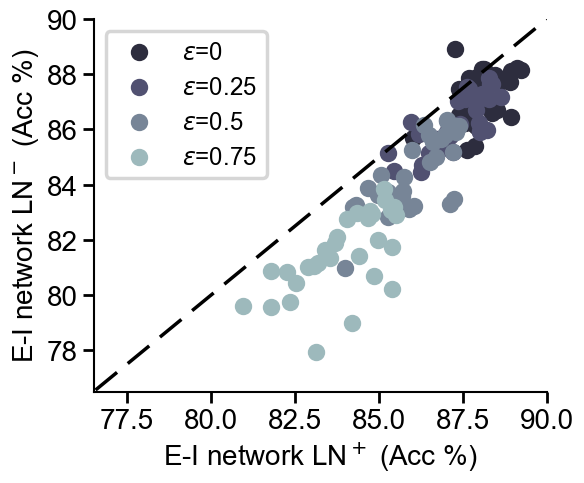

In [8]:
fig, ax = plt.subplots(figsize=(6,5))

# Example brightness factors used
brightness_values = [0, 0.25, 0.5, 0.75]

# Normalize brightness for colormap mapping
norm = mcolors.Normalize(vmin=min(brightness_values), vmax=max(brightness_values))

def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Create a grayscale colormap from 20% (dark gray) to 100% (black)
cmap = truncate_colormap(plt.get_cmap('bone'), 0.2, 0.7)

scatter_handles = []  # For legend proxy if needed
list_line = range(100)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.plot(list_line, list_line, color='black', linestyle='--')
ax.set_xlabel(f"E-I network LN$^+$ (Acc %)", fontsize=20)
ax.set_ylabel("E-I network LN$^-$ (Acc %)", fontsize=20)

for bfi in brightness_values:
    color = cmap(norm(bfi))

    runs_dict = dict()

    runs_dict["runs_ei_network_noln"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 0, "config.use_testset": True}, order="-summary_metrics.test_acc")

    runs_dict["runs_ei_network_ln"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")

    top_n = len(runs_dict["runs_ei_network_noln"])

    for top in range(top_n):
        vanilla_dann_acc = runs_dict["runs_ei_network_noln"][top].summary['test_acc']
        for rn in runs_dict["runs_ei_network_ln"]:
            if same_config(rn.config, runs_dict["runs_ei_network_noln"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                sc = ax.scatter(rn.summary['test_acc'], vanilla_dann_acc, color=color, label=f"$\epsilon$={bfi}" if top == 0 else None)
                break  # Only label once per brightness group
ax.set_xlim(76.5, 90)
ax.set_ylim(76.5, 90)
ax.legend(loc='upper left')
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Luminosity Threshold', fontsize=16)
# cbar.ax.tick_params(labelsize=14)
plt.savefig("figure1c.svg", format="svg")